## Imports

In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


## Leitura Dados

In [4]:
X = pd.read_csv('./2d/sr3/X_train.csv').drop(columns=['index', 'Unnamed: 0'])
y = pd.read_csv('./2d/sr3/y_train.csv').drop(columns=['index', 'Unnamed: 0'])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.25, random_state=42)

X_test = pd.read_csv('./2d_test/sr3/X_test.csv').drop(columns=['index', 'Unnamed: 0'])
y_test = pd.read_csv('./2d_test/sr3/y_test.csv').drop(columns=['index', 'Unnamed: 0'])


In [5]:
print(f'Train: {len(X_train)}')
print(f'Validation: {len(X_val)}')
print(f'Test: {len(X_test)}')

print('')
print(f'Input shape: {X_train.shape}')
print(f'Output shape: {y_train.shape}')

Train: 9665
Validation: 3222
Test: 1315

Input shape: (9665, 225)
Output shape: (9665, 175)


In [6]:
def df2tensor(df, ni, nj):
    t1 = torch.tensor(df.values)
    t2 = torch.reshape(t1, (len(df), -1, ni, nj))
    return t2.float()

In [7]:
X_train_t = df2tensor(X_train, 5, 5)
y_train_t = df2tensor(y_train, 5, 5)

X_val_t = df2tensor(X_val, 5, 5)
y_val_t = df2tensor(y_val, 5, 5)

X_test_t = df2tensor(X_test, 5, 5)
y_test_t = df2tensor(y_test, 5, 5)

In [8]:
sample = int(np.random.random()*len(X_train_t))
print(f'Sample {sample}')
for i,c in enumerate([c[:-2] for c in X_train.columns if c[-2:]=='_0']):
    print(c)
    print(X_train_t[sample][i])

Sample 2321
Por
tensor([[0.1200, 0.0730, 0.0860, 0.0820, 0.0900],
        [0.1150, 0.0840, 0.0740, 0.0820, 0.0780],
        [0.1050, 0.0960, 0.0900, 0.0800, 0.0710],
        [0.1250, 0.1120, 0.1020, 0.0840, 0.0720],
        [0.1380, 0.1150, 0.1160, 0.1040, 0.1000]])
PermI
tensor([[ 92.8000,  14.5000,  60.2000,  45.1000, 138.6000],
        [ 45.7000,  13.1000,  12.5000,  41.6000,  43.4000],
        [ 92.7000,  23.5000,  16.4000,  23.2000,  50.4000],
        [156.3000,  59.4000,  61.2000,  21.4000,  28.1000],
        [764.5000,  87.0000, 122.0000, 121.8000,  61.3000]])
PermJ
tensor([[ 84.2000,  19.5000,  62.5000,  66.9000, 133.5000],
        [ 66.2000,  14.5000,  14.9000,  48.5000,  42.0000],
        [100.7000,  21.3000,  20.4000,  28.9000,  52.4000],
        [178.5000,  64.4000,  66.1000,  22.0000,  51.1000],
        [850.2000, 127.1000, 136.3000, 143.5000,  70.4000]])
Pres
tensor([[331.7667, 354.7670, 377.7083, 388.1662, 392.5184],
        [356.5207, 366.3973, 382.9688, 392.7301, 396.5

In [97]:
AA = X_train_t.view(X_train_t.size(0), -1)
# AA -= AA.min(1, keepdim=True)[0]
# AA /= AA.max(1, keepdim=True)[0]
# AA = AA.view(batch_size, height, width)

In [116]:
AA = X_train_t.view(X_train_t.size(0), X_train_t.size(1), -1)
min_values, _ = AA.min(dim=2, keepdim=True)

In [14]:
AA = torch.transpose(X_train_t, 0, 1)
AA = AA.reshape(AA.size(0), -1)

min_values, _ = AA.min(dim=1, keepdim=False)
print(f'Min.values: {min_values}')

max_values, _ = AA.max(dim=1, keepdim=False)
print(f'Max.values: {max_values}')

Min.values: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0.])
Max.values: tensor([2.3900e-01, 1.3911e+03, 1.4158e+03, 1.2237e+03, 5.6159e-01, 2.5000e-01,
        2.5735e-01, 1.2237e+03, 3.5000e+01])


In [15]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        sample = (
            self.X[idx],
            self.y[idx]
        )
        return sample

In [16]:
data_train = CustomDataset(X_train_t, y_train_t)
data_val = CustomDataset(X_val_t, y_val_t)
data_test = CustomDataset(X_test_t, y_test_t)

In [17]:
batch_size = 16
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=batch_size, shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

In [18]:
for X,y in dataloader_val:
    print(f'Input shape: {X.shape}')
    print(f'Output shape: {y.shape}')
    break

Input shape: torch.Size([16, 9, 5, 5])
Output shape: torch.Size([16, 7, 5, 5])


## Neural Network

In [19]:
class Network(nn.Module):

    def __init__(self, input_size, output_size, latent_size, max_size, recurrences):
        super(Network,self).__init__()
        self.enc_1 = nn.Conv2d( input_size,  input_size, 1, padding=0)
        self.enc_2 = nn.Conv2d( input_size, latent_size, 1, padding=0)
        self.enc_3 = nn.Conv2d(latent_size, latent_size, 1, padding=0)

        self.proc_1 = nn.Conv2d(latent_size, latent_size, 3, padding=1)
        self.proc_2 = nn.Conv2d(latent_size,    max_size, 3, padding=1)
        self.proc_3 = nn.Conv2d(   max_size,    max_size, 3, padding=1)
        self.proc_4 = nn.Conv2d(   max_size, latent_size, 3, padding=1)

        self.dec_1 = nn.Conv2d( latent_size, latent_size, 1, padding=0)
        self.dec_2 = nn.Conv2d( latent_size, output_size, 1, padding=0)
        self.dec_3 = nn.Conv2d( output_size, output_size, 1, padding=0)

        self.recurrences = recurrences

    def forward(self, x):
        x = self.enc_1(x)
        x = F.relu(x)
        x = self.enc_2(x)
        x = F.relu(x)
        x = self.enc_3(x)
        x = F.relu(x)

        for _ in range(self.recurrences):
            x = self.proc_1(x)
            x = F.relu(x)
            x = self.proc_2(x)
            x = F.relu(x)
            x = self.proc_3(x)
            x = F.relu(x)
            x = self.proc_4(x)
            x = F.relu(x)

        x = self.dec_1(x)
        x = F.relu(x)
        x = self.dec_2(x)
        x = F.relu(x)
        x = self.dec_3(x)
        return x

In [20]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=16,
    max_size=32,
    recurrences=5)

some_data = X_train_t
print(f'Input: {some_data.shape}')
loss_fn = nn.MSELoss()
result = model(some_data)
print(f'Result: {result.shape}')

loss = loss_fn(result, y_train_t)
loss.backward()
print(f'Loss = {loss:0.2f}')

Input: torch.Size([9665, 9, 5, 5])
Result: torch.Size([9665, 7, 5, 5])
Loss = 32205.75


In [21]:
torch.onnx.export(model, X_test_t, 'test.onnx', input_names=["features"], output_names=["results"])
# https://machinelearningmastery.com/visualizing-a-pytorch-model/
# https://netron.app/

In [22]:
total = 0
for name, param in model.named_parameters():
    print(f"Layer: {name} | Parameters: {param.numel()}")
    total += param.numel()
print(f'Total: {total}')

Layer: enc_1.weight | Parameters: 81
Layer: enc_1.bias | Parameters: 9
Layer: enc_2.weight | Parameters: 144
Layer: enc_2.bias | Parameters: 16
Layer: enc_3.weight | Parameters: 256
Layer: enc_3.bias | Parameters: 16
Layer: proc_1.weight | Parameters: 2304
Layer: proc_1.bias | Parameters: 16
Layer: proc_2.weight | Parameters: 4608
Layer: proc_2.bias | Parameters: 32
Layer: proc_3.weight | Parameters: 9216
Layer: proc_3.bias | Parameters: 32
Layer: proc_4.weight | Parameters: 4608
Layer: proc_4.bias | Parameters: 16
Layer: dec_1.weight | Parameters: 256
Layer: dec_1.bias | Parameters: 16
Layer: dec_2.weight | Parameters: 112
Layer: dec_2.bias | Parameters: 7
Layer: dec_3.weight | Parameters: 49
Layer: dec_3.bias | Parameters: 7
Total: 21801


## Ajuste

In [23]:
def plot_losses(train_losses, val_losses):
    plt.plot(range(1,len(train_losses)+1), train_losses, label='Train')
    plt.plot(range(1,len(train_losses)+1), val_losses, label='Val')
    plt.yscale("log")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.title("Model Training")
    plt.legend()
    plt.grid(True)
    plt.show()

In [24]:
def train_loop(dataloader, model, loss_fn, optimizer, verbose=False):
    size = len(dataloader.dataset)
    model.train()
    losses = []
    for batch, (X, y) in enumerate(dataloader):
        optimizer.zero_grad()
        pred = model(X)
        loss = loss_fn(pred, y)
        losses.append(loss)

        loss.backward()
        optimizer.step()

        if verbose:
            if batch % 100 == 0:
                loss, current = loss.item(), batch * batch_size + len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    return float(torch.tensor(losses).mean())

def test_loop(dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()

    test_loss /= num_batches
    return test_loss

def train(model: Network,
          train_dataloader: DataLoader,
          val_dataloader: DataLoader,
          epochs: int,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module,
          file_name='model.pth',
          verbose=False):

    best_val = np.inf
    train_loss = []
    val_loss = []
    print("=> Starting training")
    for t in range(epochs):
        if verbose:
            print(f"Epoch {t+1}\n-------------------------------")
        train_loss.append(train_loop(train_dataloader, model, loss_fn, optimizer, verbose))
        val_loss.append(  test_loop(val_dataloader, model, loss_fn))
        star = ''
        if val_loss[-1] < best_val:
            best_val = val_loss[-1]
            torch.save(model, file_name)
            star = '*'
        print(f' {t + 1}: train = {train_loss[-1]:0.4g}, val = {val_loss[-1]:0.4g}{star}')
    print("Done!")
    best_model = torch.load(file_name)
    return best_model, (train_loss, val_loss)

=> Starting training
 1: train = 2.937e+04, val = 2.406e+04*
 2: train = 1.748e+04, val = 1.471e+04*
 3: train = 1.368e+04, val = 1.281e+04*
 4: train = 1.198e+04, val = 1.117e+04*
 5: train = 1.041e+04, val = 9738*
 6: train = 9154, val = 8621*
 7: train = 8197, val = 7773*
 8: train = 7482, val = 7089*
 9: train = 6850, val = 6510*
 10: train = 6338, val = 6624
 11: train = 5907, val = 5587*
 12: train = 5524, val = 5271*
 13: train = 5078, val = 4814*
 14: train = 4770, val = 4515*
 15: train = 4438, val = 4277*
 16: train = 4151, val = 3952*
 17: train = 3897, val = 3655*
 18: train = 3658, val = 3428*
 19: train = 3454, val = 3292*
 20: train = 3230, val = 3075*
 21: train = 3069, val = 2851*
 22: train = 2919, val = 2707*
 23: train = 2731, val = 2595*
 24: train = 2658, val = 2592*
 25: train = 2502, val = 2327*
 26: train = 2431, val = 2231*
 27: train = 2342, val = 2189*
 28: train = 2256, val = 2430
 29: train = 2184, val = 2119*
 30: train = 2119, val = 1975*
 31: train = 20

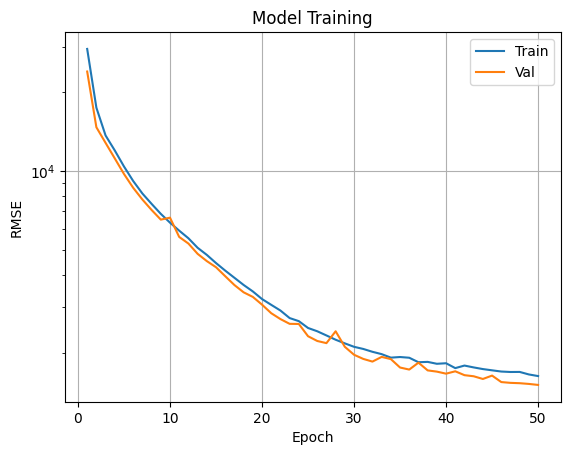

Test loss = 3266 (last model)
Test loss = 3266 (best model)


In [25]:
model = Network(
    input_size=9,
    output_size=7,
    latent_size=16,
    max_size=32,
    recurrences=2)
loss_fn = nn.MSELoss()

batch_size = 256
dataloader_train = DataLoader(data_train, batch_size=batch_size, shuffle=True)
dataloader_val = DataLoader(data_val, batch_size=len(data_val), shuffle=False)
dataloader_test = DataLoader(data_test, batch_size=batch_size, shuffle=False)

epochs = 500
optimizer = torch.optim.RMSprop(model.parameters(), lr = 0.0001)  # ok
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=0.5)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adadelta(model.parameters(), lr=0.0001)
# optimizer = torch.optim.Adamax(model.parameters(), lr=0.0001)  # ok
# optimizer = torch.optim.ASGD(model.parameters(), lr=0.0001)
# optimizer = torch.optim.NAdam(model.parameters(), lr=0.0001)  # ok

best_model, (train_loss, val_loss) = train(model, dataloader_train, dataloader_val, epochs, optimizer, loss_fn)

plot_losses(train_loss, val_loss)

test_loss = test_loop(dataloader_test, model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (last model)')
test_loss = test_loop(dataloader_test, best_model, loss_fn)
print(f'Test loss = {test_loss:0.4g} (best model)')

## Teste Recorrência

In [30]:
import sys
sys.path.insert(0, '../python')
from simpython.cmg import sr3reader
import read_sr3

In [29]:
sim_days = 365*5
sim_number = 10

file_name = f'./2d_test/sr3/sens_{sim_number}.sr3'

In [143]:
sr3 = sr3reader.Sr3Reader(file_name)
sr3_data = read_sr3.read_data(sr3, days=[1])

Pwf_prod = sr3.get_data(
    element_type='well',
    property_names='BHP',
    element_names='P01',
    days=range(1, sim_days))

Np_prod = sr3.get_data(
    element_type='well',
    property_names='NP',
    element_names='P01',
    days=range(1, sim_days))

Qo_prod = sr3.get_data(
    element_type='well',
    property_names='QO',
    element_names='P01',
    days=range(1, sim_days))

Wp_prod = sr3.get_data(
    element_type='well',
    property_names='WP',
    element_names='P01',
    days=range(1, sim_days))

Pwf_inj = sr3.get_data(
    element_type='well',
    property_names='BHP',
    element_names='I01',
    days=range(1, sim_days))

Wp_inj = sr3.get_data(
    element_type='well',
    property_names='WP',
    element_names='I01',
    days=range(1, sim_days))

In [102]:
wells = {'P01':0, 'I01':24}
sim_data = read_sr3.organize_data(sr3_data[0], wells)

t1 = torch.tensor(sim_data['in'])
t2 = torch.reshape(t1, (-1, 5, 5))
sim_data_t = t2.float()
sim_data_t = sim_data_t

In [118]:
pred = best_model(sim_data_t)

In [77]:
[c[:-2] for c in X_train.columns if c[-2:]=='_0']

['Por', 'PermI', 'PermJ', 'Pres', 'Sw', 'Kro', 'Krw', 'Pwf', 'QwI']

In [78]:
[c[:-2] for c in y_train.columns if c[-2:]=='_0']

['Pres', 'Sw', 'Kro', 'Krw', 'Qo', 'Qw', 'PwfI']

In [105]:
sim_data_t.shape

torch.Size([9, 5, 5])

In [106]:
pred.shape

torch.Size([7, 5, 5])

In [111]:
def value2map(value, position):
    array_ = np.zeros(25)
    array_[position] = value
    t1_ = torch.tensor(array_)
    t2_ = torch.reshape(t1_, (-1, 5, 5))
    return t2_.float()

In [150]:
Qo_nn = []
Qw_nn = []
Pwf_inj_nn = []
current_state = sim_data_t.clone()

for i in range(1,sim_days-1):

    pred = best_model(current_state)

    Qo_nn.append(float(pred[4][0][0]))
    Qw_nn.append(float(pred[5][0][0]))
    Pwf_inj_nn.append(float(pred[6][4][4]))

    stat_data = sim_data_t[0:3]
    new_state = pred[0:4]
    control_Pwf = value2map((Pwf_prod[i,1]+Pwf_prod[i-1,1])/2, 0)
    control_Qwi = value2map(Wp_inj[i,1]-Wp_inj[i-1,1], 24)
    current_state = torch.cat((stat_data, new_state, control_Pwf, control_Qwi), dim=0)

In [97]:
def plot_time_series(ts1, ts2=None, label1='1', label2='2'):
    plt.plot(ts1, label=label1)
    if ts2 is not None:
        plt.plot(ts2, label=label2)
    plt.xlabel("days")
    plt.ylabel("-")
    plt.title("Results")
    if ts2 is not None:
        plt.legend()
    plt.grid(True)
    plt.show()

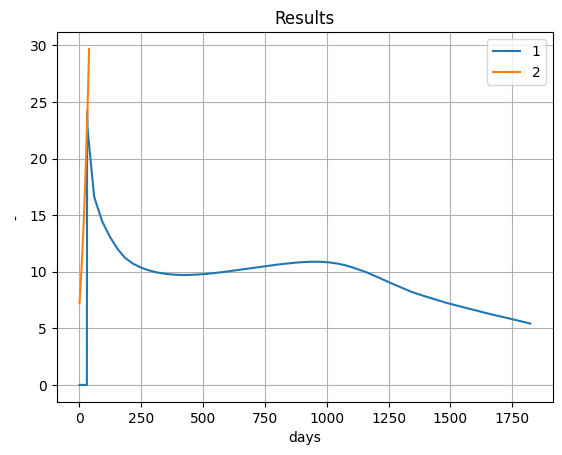

In [155]:
plot_time_series(Qo_prod[:,1], Qo_nn[:40])

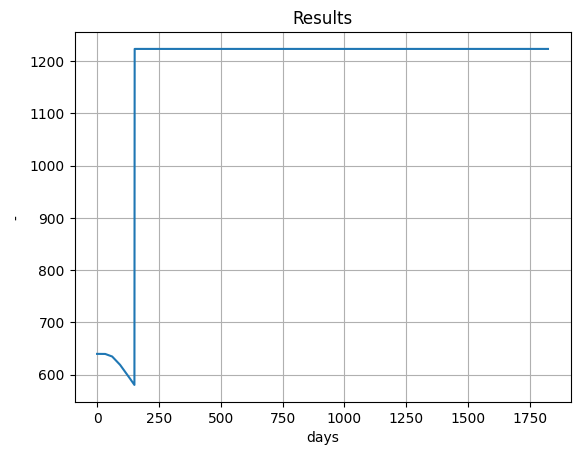

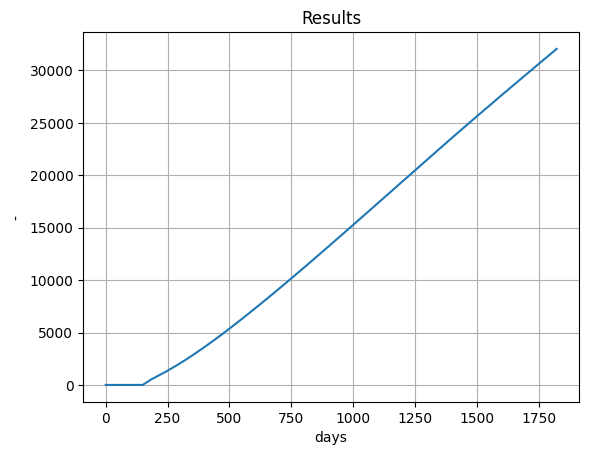

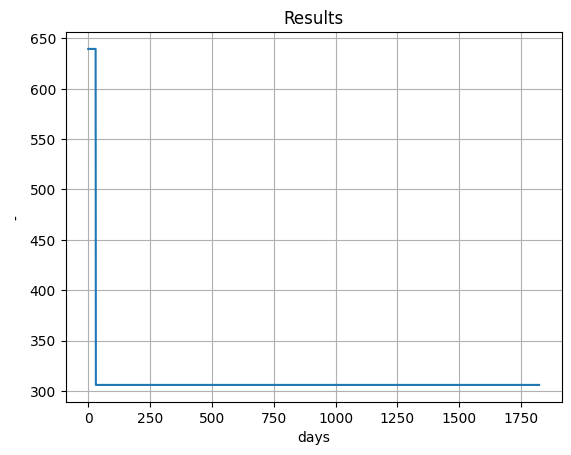

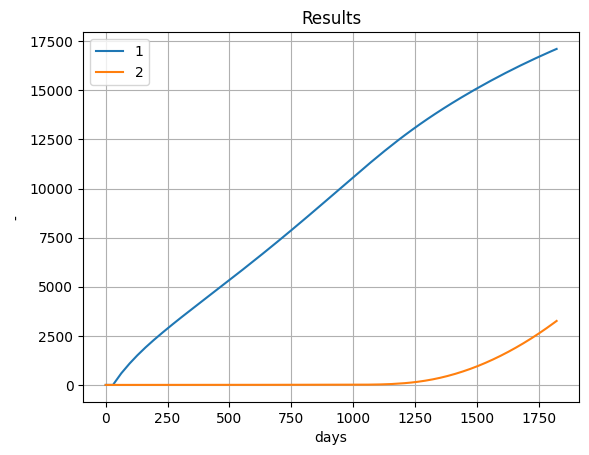

In [122]:
plot_time_series(Pwf_inj[:,1])
plot_time_series(Wp_inj[:,1])
plot_time_series(Pwf_prod[:,1])
plot_time_series(Np_prod[:,1], Wp_prod[:,1])

In [93]:
Pwf_prod

array([[1.00000000e+00, 6.39604870e+02],
       [2.00000000e+00, 6.39604584e+02],
       [3.00000000e+00, 6.39604594e+02],
       ...,
       [1.82200000e+03, 3.05914864e+02],
       [1.82300000e+03, 3.05914864e+02],
       [1.82400000e+03, 3.05914864e+02]])